## Попробуем TabMixer, подбор гиперпараметров Optuna
- **помним про временные split, признаки и метрики те же**

## 1. Импорты


In [1]:
import os, warnings, random, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch, torch.nn as nn
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc,
                             average_precision_score, confusion_matrix)
from sklearn.preprocessing import RobustScaler
from IPython.display import clear_output

import optuna
from optuna.samplers import TPESampler
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

RANDOM_STATE = 42
def set_seed(seed=RANDOM_STATE):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## 2. Загрузка

In [2]:
def find_path_within_project(project_name, path_to_data):
    current_path = os.getcwd()
    while True:
        if project_name in os.listdir(current_path):
            return os.path.join(current_path, project_name, path_to_data)
        parent_path = os.path.dirname(current_path)
        if parent_path == current_path:
            raise FileNotFoundError(f"Проект '{project_name}' не найден")
        current_path = parent_path

full_path = find_path_within_project(
    "anomaly_detection_project",
    os.path.join("data", "raw", "creditcard_1_02_00.csv")
)
df = pd.read_csv(full_path)
print(f"\nРазмер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")


Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## 3.сплиты

In [3]:
time_col = 'Time_abs_hour'
def get_train_test(df, col, train_finish, train_start=0, test_finish=0, gap=0):
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test  = df[(df[col] >= test_start)  & (df[col] <= test_finish)]
    print(f"train: {df_train[col].min()}–{df_train[col].max()} | test: {df_test[col].min()}–{df_test[col].max()}")
    return df_train, df_test

train_finish = df[time_col].max() - 8
df_train, df_test = get_train_test(df, time_col, train_finish)

train_finish_2 = df_train[time_col].max() - 8
df_train_2, df_val = get_train_test(df_train, time_col, train_finish_2)

train: 0.0–39.0 | test: 40.0–47.0
train: 0.0–31.0 | test: 32.0–39.0


## 4. Признаки и целевая переменная

In [4]:
unnecessary_cols = ['Time','Amount','Time_hour','Time_day','Amount_log', time_col]
target_col = 'Class'
drop_cols = [target_col] + unnecessary_cols

def xy(df):
    X = df.drop(drop_cols, axis=1).astype('float32').values
    y = df[target_col].values
    return X, y

X_tr,   y_tr   = xy(df_train_2)
X_val,  y_val  = xy(df_val)
X_test, y_test = xy(df_test)
X_train, y_train = xy(df_train)

# Определим n_features до objective
n_features = X_tr.shape[1]

## 5. Torch Dataset / Loader

In [5]:
# обёртка для табличных данных, 
class TabDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]
# быстро получаем готовый DataLoader для обучения модели
def build_loaders(X, y, batch_size, shuffle=True):
    ds = TabDataset(X, y)
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=True)

## 6. Модель TabMixer (MLP-Mixer)

In [6]:
class TabMixer(nn.Module):
    """
    Упрощённый MLP-Mixer для таблиц:
    
     Концепция MLP-Mixer :
        Оригинальный MLP-Mixer был придуман для изображений и состоял из чередующихся блоков:
            Token-mixing – смешивает информацию между пикселями (или «патчами») внутри одного канала.
            Channel-mixing – смешивает информацию между каналами внутри одного пикселя.
        Для таблиц:
            «Пиксели» → строки (объекты).
            «Каналы» → признаки (столбцы).
        Но в этом упрощённом варианте мы не разворачиваем матрицу и не делаем два отдельных MLP.
        Вместо этого вся «смесь» делается одним MLP-блоком, который применяется к каждой строке независимо.
        То есть фактически это обычный MLP-encoder, но название «Mixer» подчёркивает идеологическое родство.
    """
    def __init__(self, n_features, dim=128, depth=4, dropout=0.1):
        super().__init__()
        self.embed = nn.Linear(n_features, dim)
        layers = []
        for _ in range(depth):
            layers += [
                nn.LayerNorm(dim),
                nn.Linear(dim, dim*4),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(dim*4, dim),
                nn.Dropout(dropout)
            ]
        self.mixer = nn.Sequential(*layers)
        self.head = nn.Linear(dim, 1)

    def forward(self, x):
        x = self.embed(x)            # (B, dim)
        x = self.mixer(x)
        return self.head(x).squeeze(-1)

## 7. Функция потерь и метрика

In [7]:
class PR_AUC_Metric:
    def __init__(self):
        self._name = "pr_auc"
        self._maximize = True
    def __call__(self, y_true, y_score):
        return average_precision_score(y_true, y_score)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(y_tr)/y_tr.sum()], device=device))

## 8. Optuna — подбор гиперпараметров

In [8]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256])
    dim = trial.suggest_int("dim", 64, 128, step=64)
    depth = trial.suggest_int("depth", 1, 4)
    dropout = trial.suggest_float("dropout", 0.02, 0.15)

    model = TabMixer(n_features, dim=dim, depth=depth, dropout=dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)


    train_loader = build_loaders(X_tr, y_tr, batch_size)
    val_loader   = build_loaders(X_val, y_val, batch_size, shuffle=False)

    best_pr_auc = 0.0
    patience, counter = 5, 0

    for epoch in range(50):
        # train
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # eval
        model.eval()
        with torch.no_grad():
            preds = torch.sigmoid(model(torch.tensor(X_val, device=device))).cpu().numpy()
        pr_auc = average_precision_score(y_val, preds)
        
        if pr_auc > best_pr_auc + 1e-4:
            best_pr_auc = pr_auc
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            break
    print(f"\nУчились {epoch} эпох.")
    return best_pr_auc


set_seed()
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=15, show_progress_bar=True)

print("Best trial:", study.best_trial.params)
print("Best PR-AUC:", study.best_value)

[I 2025-08-31 00:43:35,221] A new study created in memory with name: no-name-62a3697e-c1df-4b78-bf43-d0643bd3ad37


  0%|          | 0/15 [00:00<?, ?it/s]


Учились 5 эпох.
[I 2025-08-31 00:43:55,785] Trial 0 finished with value: 0.7578263464882509 and parameters: {'lr': 5.6115164153345e-05, 'batch_size': 128, 'dim': 128, 'depth': 1, 'dropout': 0.04027928764370635}. Best is trial 0 with value: 0.7578263464882509.

Учились 16 эпох.
[I 2025-08-31 00:44:50,124] Trial 1 finished with value: 0.7654568431427338 and parameters: {'lr': 1.3066739238053272e-05, 'batch_size': 128, 'dim': 128, 'depth': 1, 'dropout': 0.14608828078105926}. Best is trial 1 with value: 0.7654568431427338.

Учились 9 эпох.
[I 2025-08-31 00:45:33,342] Trial 2 finished with value: 0.6868666164290497 and parameters: {'lr': 0.000462258900102083, 'batch_size': 128, 'dim': 64, 'depth': 2, 'dropout': 0.08821833611219093}. Best is trial 1 with value: 0.7654568431427338.

Учились 5 эпох.
[I 2025-08-31 00:45:50,133] Trial 3 finished with value: 0.7196145109427619 and parameters: {'lr': 7.309539835912905e-05, 'batch_size': 256, 'dim': 64, 'depth': 2, 'dropout': 0.06762703962817992}.

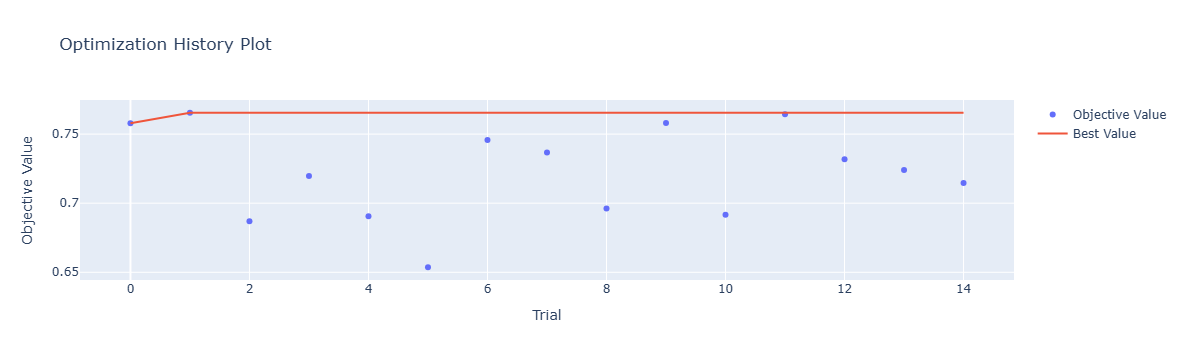

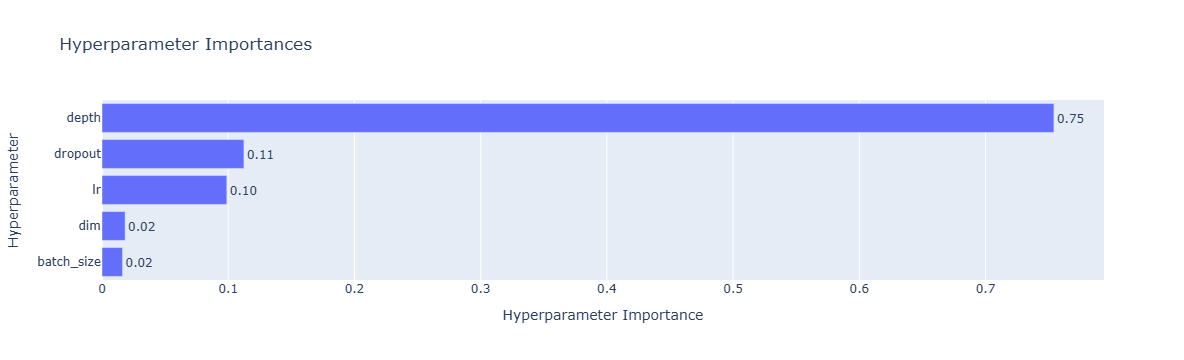

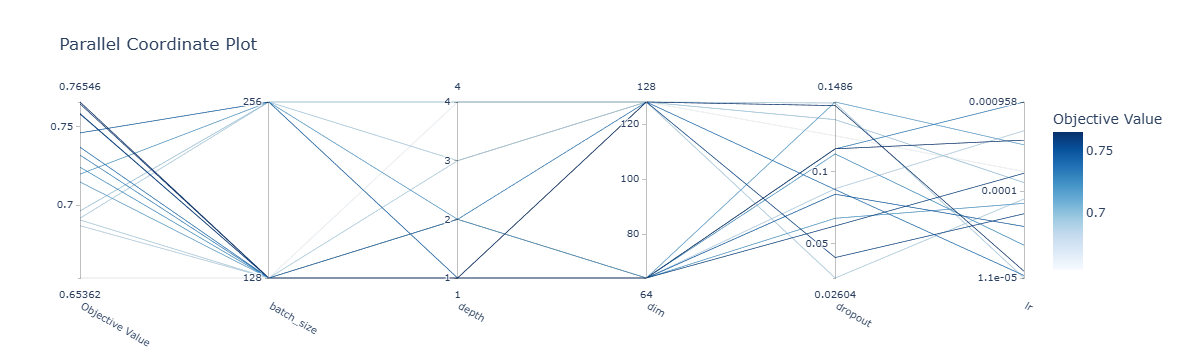

In [9]:
# optuna визуализация
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

## 9. Обучение финальной модели

In [10]:
def train_with_plot_and_scheduler(model, train_loader, val_loader, optimizer, criterion, epochs):

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

    train_losses = []
    val_losses = []
    pr_aucs = []
    roc_aucs = []
    lrs = []

    for epoch in range(epochs):
        model.train()  # настраиваем на обучение
        total_loss, n = 0., 0  # задаём стартовые значения
        for X, y in train_loader:
            X, y = X.to(device), y.float().to(device)
            optimizer.zero_grad()    # обнуляем градиенты
            preds = model(X)  # prediction
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            # собираем результат в кучку
            total_loss += loss.item() * len(X)
            n += len(X)
        # среднее за эпоху
        train_loss = total_loss / n

        # 
        model.eval()  # режим оценки
        # стартовая инициализация
        total_loss, n = 0., 0
        all_preds, all_labels = [], []
        
        for X, y in val_loader:
            X, y = X.to(device), y.float().to(device)
            with torch.no_grad():
                preds = torch.sigmoid(model(X))
            total_loss += criterion(preds, y).item() * len(X)
            n += len(X)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    
        preds = torch.cat(all_preds).numpy()
        labels = torch.cat(all_labels).numpy()
        pr_auc = auc(*precision_recall_curve(labels, preds)[1::-1])
        roc_auc = roc_auc_score(labels, preds)
        val_loss = total_loss / n
            

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        pr_aucs.append(pr_auc)
        roc_aucs.append(roc_auc)
        lrs.append(optimizer.param_groups[0]['lr'])

        scheduler.step()  # обновляем learning rate

        # Обновление графика
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        # Потери
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss по эпохам')
        plt.legend()
        plt.xlim(0, epochs)

        # Метрики
        plt.subplot(1, 3, 2)
        plt.plot(pr_aucs, label='PR AUC')
        plt.plot(roc_aucs, label='ROC AUC')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Тест Metrics')
        plt.legend()
        plt.xlim(0, epochs)

        # Learning Rate
        plt.subplot(1, 3, 3)
        plt.plot(lrs, label='Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.title('Learning Rate Decay')
        plt.legend()
        plt.xlim(0, epochs)

        plt.tight_layout()
        plt.show()

        print(f"Эпоха {epoch+1}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, PR AUC: {pr_auc:.4f}, ROC AUC: {roc_auc:.4f}, LR: {lrs[-1]:.6f}")


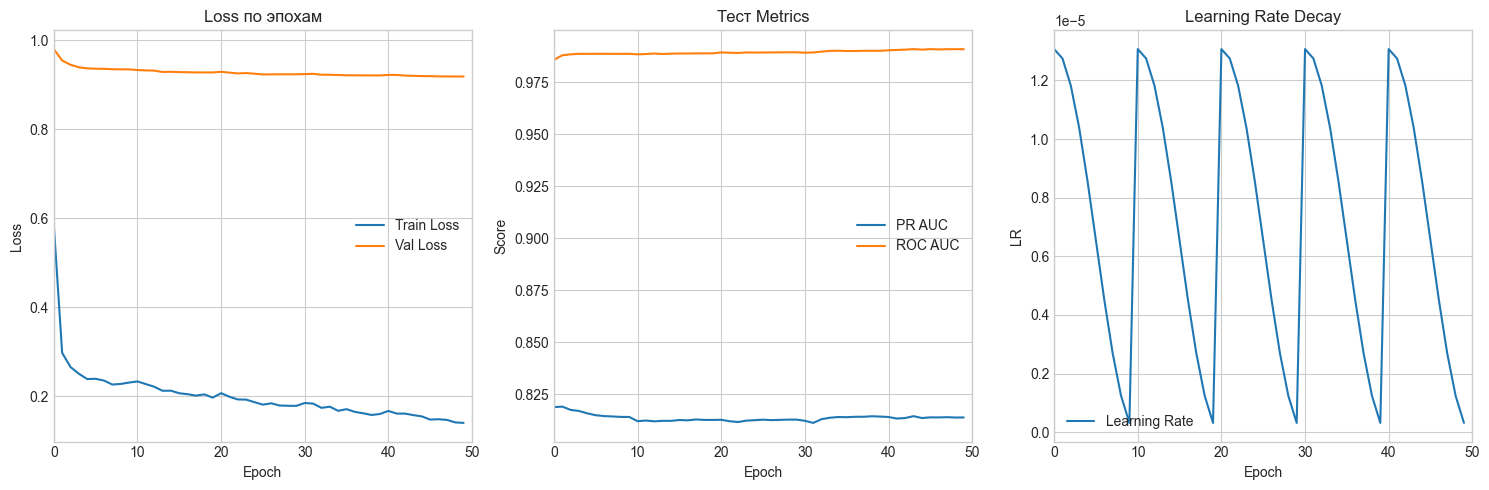

Эпоха 50/50 — Train Loss: 0.1401, Val Loss: 0.9190, PR AUC: 0.8138, ROC AUC: 0.9908, LR: 0.000000


In [11]:
set_seed()

best = study.best_params
model =  TabMixer(n_features, dim=best["dim"], depth=best["depth"], dropout=best["dropout"]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=best["lr"])

batch_size = best["batch_size"]

train_with_plot_and_scheduler(model, build_loaders(X_train, y_train, batch_size),
                              build_loaders(X_test, y_test, batch_size, shuffle=False),
                              optimizer, loss_fn, 50)

## 10. Оценка на тесте

In [12]:
model.eval()
with torch.no_grad():
    y_score = torch.sigmoid(model(torch.tensor(X_test, device=device))).cpu().numpy()

y_pred = (y_score >= 0.5).astype(int)

pr_auc = average_precision_score(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"PR-AUC={pr_auc:.4f} ROC-AUC={roc_auc:.4f} Precision={precision:.3f} Recall={recall:.3f} F1={f1:.3f}")

PR-AUC=0.8141 ROC-AUC=0.9908 Precision=0.074 Recall=0.883 F1=0.137


## 11. Подбор порога по валидации

In [15]:
with torch.no_grad():
    val_score = torch.sigmoid(model(torch.tensor(X_val, device=device))).cpu().numpy()

prec, rec, thr = precision_recall_curve(y_val, val_score)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_thr = thr[np.nanargmax(f1_scores)]
print(f"Оптимальный порог по val: {best_thr:.7f}")

Оптимальный порог по val: 0.9999499


## 12. Финальные метрики и визуализация

Test (порог подобран по валидации) PR-AUC=0.8138 Precision=0.963 Recall=0.675 F1=0.794


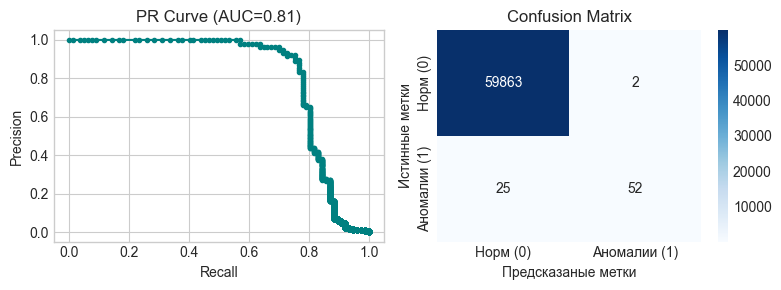

In [14]:
y_pred_test = (y_score >= best_thr).astype(int)
precision = precision_score(y_test, y_pred_test)
recall    = recall_score(y_test, y_pred_test)
f1        = f1_score(y_test, y_pred_test)
prec, rec, _ = precision_recall_curve(y_test, y_score)
pr_auc = auc(rec, prec)

print("Test (порог подобран по валидации) "
      f"PR-AUC={pr_auc:0.4f} Precision={precision:0.3f} Recall={recall:0.3f} F1={f1:.3f}")

# визуализация
labels = ['Норм (0)', 'Аномалии (1)']
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(rec, prec, marker='.', color='teal')
axs[0].set_xlabel("Recall"); axs[0].set_ylabel("Precision")
axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_xlabel("Предсказаные метки"); axs[1].set_ylabel("Истинные метки")
axs[1].set_title("Confusion Matrix")
plt.tight_layout(); plt.show()

## 13. Сохранение

In [ ]:
# torch.save(model.state_dict(), "tabmixer_creditcard.pt")

## 14. Выводы
**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
**Модель**  
- **типа TabMixer**
  
**Подбор гиперпараметров**
- **Optuna**
  
**Метрики**  | F1   | PR AUC |
- **Test**     | 0.79 | 0.81   |

**Вывод**
- Модель справилась с задачей детекции аномалий.
упрощённый TabMixer(таже полносвязная сеть) показал устойчивую и высокую производительность на тестовой выборке:
- - PR-AUC: 0.81 — хороший результат для несбалансированных данных (аномалий всего 0.17%).
- -  Precision: 0.96, Recall: 0.68, F1: 0.79 — при пороге 0.9999499, подобранном на валидации
- Подбор гиперпараметров через Optuna был эффективен.
- - Оптимизация позволила улучшить PR-AUC с ~0.7 до 0.76 на валидации и добиться устойчивой работы на тесте.
- Модель справилась с дисбалансом классов (0.17% аномалий)
- Подбор порога классификации - важен: Исходно модель с порогом 0.5 давала высокий Recall (0.88) но низкий Precision (0.07). Это типично для несбалансированных данных. Последующий подбор оптимального порога  на валидационной выборке позволил найти баланс и значительно улучшить F1-меру